In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# Load the dataset

In [2]:
df = pd.read_csv("consommation-quotidienne-brute.csv", sep=";")
df

Date - Heure        Date  Heure  \
0       2024-12-31T22:30:00+00:00  31/12/2024  23:30   
1       2024-12-31T22:00:00+00:00  31/12/2024  23:00   
2       2024-12-31T21:30:00+00:00  31/12/2024  22:30   
3       2024-12-31T21:00:00+00:00  31/12/2024  22:00   
4       2024-12-31T20:30:00+00:00  31/12/2024  21:30   
...                           ...         ...    ...   
227947  2012-01-01T01:00:00+00:00  01/01/2012  02:00   
227948  2012-01-01T00:30:00+00:00  01/01/2012  01:30   
227949  2012-01-01T00:00:00+00:00  01/01/2012  01:00   
227950  2011-12-31T23:30:00+00:00  01/01/2012  00:30   
227951  2011-12-31T23:00:00+00:00  01/01/2012  00:00   

        Consommation brute gaz (MW PCS 0°C) - GRTgaz Statut - GRTgaz  \
0                                                NaN             NaN   
1                                            52474.0       Définitif   
2                                                NaN             NaN   
3                                            55779.0       Définitif   
4                                                NaN             NaN   
...                                              ...             ...   
227947                                       52251.0       Définitif   
227948                                           NaN             NaN   
227949                                       52236.0       Définitif   
227950                                           NaN             NaN   
227951                                       52099.0       Définitif   

        Consommation brute gaz (MW PCS 0°C) - Teréga Statut - Teréga  \
0                                                NaN             NaN   
1                                             4201.0      Définitive   
2                                                NaN             NaN   
3                                             4687.0      Définitive   
4                                                NaN             NaN   
...                                              ...             ...   
227947                                        3214.0       Définitif   
227948                                           NaN             NaN   
227949                                        3208.0       Définitif   
227950                                           NaN             NaN   
227951                                        3254.0       Définitif   

        Consommation brute gaz totale (MW PCS 0°C)  \
0                                              NaN   
1                                          56675.0   
2                                              NaN   
3                                          60466.0   
4                                              NaN   
...                                            ...   
227947                                     55465.0   
227948                                         NaN   
227949                                     55444.0   
227950                                         NaN   
227951                                     55353.0   

        Consommation brute électricité (MW) - RTE Statut - RTE  \
0                                             NaN    Consolidé   
1                                             NaN    Consolidé   
2                                             NaN    Consolidé   
3                                             NaN    Consolidé   
4                                             NaN    Consolidé   
...                                           ...          ...   
227947                                    55531.0    Définitif   
227948                                    56075.0    Définitif   
227949                                    56230.0    Définitif   
227950                                    58314.0    Définitif   
227951                                    59610.0    Définitif   

        Consommation brute totale (MW) flag_ignore  
0                                  NaN         oui  
1                                  NaN         non  
2                

# Data Cleaning

In [3]:
df = df[["Date - Heure", "Date", "Heure", "Consommation brute gaz totale (MW PCS 0°C)"]]
df.head(10)

Date - Heure        Date  Heure  \
0  2024-12-31T22:30:00+00:00  31/12/2024  23:30   
1  2024-12-31T22:00:00+00:00  31/12/2024  23:00   
2  2024-12-31T21:30:00+00:00  31/12/2024  22:30   
3  2024-12-31T21:00:00+00:00  31/12/2024  22:00   
4  2024-12-31T20:30:00+00:00  31/12/2024  21:30   
5  2024-12-31T20:00:00+00:00  31/12/2024  21:00   
6  2024-12-31T19:30:00+00:00  31/12/2024  20:30   
7  2024-12-31T19:00:00+00:00  31/12/2024  20:00   
8  2024-12-31T18:30:00+00:00  31/12/2024  19:30   
9  2024-12-31T18:00:00+00:00  31/12/2024  19:00   

   Consommation brute gaz totale (MW PCS 0°C)  
0                                         NaN  
1                                     56675.0  
2                                         NaN  
3                                     60466.0  
4                                         NaN  
5                                     65114.0  
6                                         NaN  
7                                     68347.0  
8                                         NaN  
9                                     71478.0

In [4]:
#Since there is a value every hour, as specified in the dataset description on data.gouv.fr, we delete every half-hour.
df = df.drop("Date - Heure", axis=1)
df = df.rename(columns={"Consommation brute gaz totale (MW PCS 0°C)": "Total_gas_consumption"})
df = df.dropna(subset=["Total_gas_consumption"]).reset_index(drop=True)
df["Date"] = pd.to_datetime(df["Date"].astype(str).str.replace("/", "-") + " " + df["Heure"].astype(str), format="%d-%m-%Y %H:%M")
df = df.drop("Heure", axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113972 entries, 0 to 113971
Data columns (total 2 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Date                   113972 non-null  datetime64[ns]
 1   Total_gas_consumption  113972 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.7 MB


In [5]:
#Visualize the situation with a dynamic graph in order to zoom in to locate specificity of the dataset. 
px.line(df, df["Date"], df["Total_gas_consumption"])

<Axes: ylabel='Frequency'>

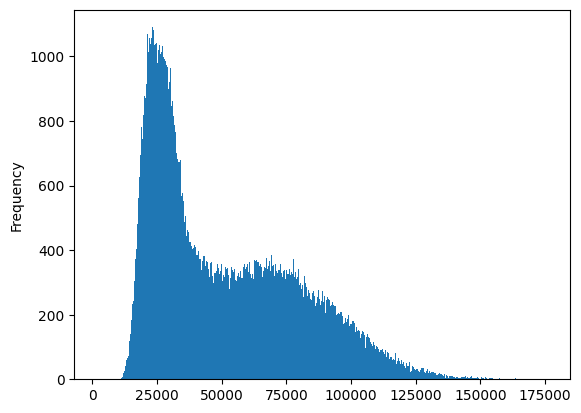

In [6]:
df["Total_gas_consumption"].plot(kind="hist", bins=500)

# Pre-processing for our XGBoost Model

In [7]:
#Sort dataset from earliest to latest date
df = df.sort_values(by="Date", ascending=True)

In [8]:
#Locate identical datas
df["Date"].value_counts()

Date
2020-12-05 00:00:00    2
2024-12-29 15:00:00    1
2012-01-03 02:00:00    1
2024-12-30 23:00:00    1
2024-12-30 15:00:00    1
                      ..
2024-12-30 11:00:00    1
2024-12-30 12:00:00    1
2024-12-30 13:00:00    1
2024-12-30 14:00:00    1
2012-01-01 17:00:00    1
Name: count, Length: 113971, dtype: int64

In [9]:
#Average the values of the two similar dates
df = df.groupby("Date", as_index=True).mean()

## Creating features for the model

In [10]:
def create_features(df):
    """
    Create temporal features for our dataset
    """
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["dayofmonth"] = df.index.day
    df["weekofyear"] = df.index.isocalendar().week
    df["dayofyear"] = df.index.dayofyear
    df["month"] = df.index.month
    df["quarter"] = df.index.quarter
    df["year"] = df.index.year
    #Creates lag columns in a DataFrameshangover list
    #lagged_features = [df["Consommation_totale_gaz"].shift(lag).rename(f"lags_{lag}") for lag in range(1, 25)]   
    # Concatenates all columns at once
    #df = pd.concat([df] + lagged_features, axis=1)
    return df

def add_lags(df, col):
    """
    Implement lags of 1, 2 and 3 years
    Takes two argument : a DataFrame and the target column used to implement the lags
    """
    df = df.copy()
    df['lags_1'] = df[col].shift(freq='365D')
    df['lags_2'] = df[col].shift(freq='730D')
    df['lags_3'] = df[col].shift(freq='1095D')
    return df

df = create_features(df)
df = add_lags(df, col="Total_gas_consumption")
df = df.dropna()
df

Total_gas_consumption  hour  dayofweek  dayofmonth  \
Date                                                                      
2014-12-31 00:00:00                80481.0     0          2          31   
2014-12-31 01:00:00                79832.0     1          2          31   
2014-12-31 02:00:00                80948.0     2          2          31   
2014-12-31 03:00:00                82585.0     3          2          31   
2014-12-31 04:00:00                86115.0     4          2          31   
...                                    ...   ...        ...         ...   
2024-12-31 19:00:00                71478.0    19          1          31   
2024-12-31 20:00:00                68347.0    20          1          31   
2024-12-31 21:00:00                65114.0    21          1          31   
2024-12-31 22:00:00                60466.0    22          1          31   
2024-12-31 23:00:00                56675.0    23          1          31   

                     weekofyear  dayofyear  month  quarter  year   lags_1  \
Date                                                                        
2014-12-31 00:00:00           1        365     12        4  2014  65069.0   
2014-12-31 01:00:00           1        365     12        4  2014  65064.0   
2014-12-31 02:00:00           1        365     12        4  2014  66221.0   
2014-12-31 03:00:00           1        365     12        4  2014  67684.0   
2014-12-31 04:00:00           1        365     12        4  2014  71070.0   
...                         ...        ...    ...      ...   ...      ...   
2024-12-31 19:00:00           1        366     12        4  2024  55446.0   
2024-12-31 20:00:00           1        366     12        4  2024  53986.0   
2024-12-31 21:00:00           1        366     12        4  2024  51883.0   
2024-12-31 22:00:00           1        366     12        4  2024  47358.0   
2024-12-31 23:00:00           1        366     12        4  2024  43913.0   

                      lags_2   lags_3  
Date                                   
2014-12-31 00:00:00  59654.0  55353.0  
2014-12-31 01:00:00  59866.0  55444.0  
2014-12-31 02:00:00  60626.0  55465.0  
2014-12-31 03:00:00  61802.0  56048.0  
2014-12-31 04:00:00  64983.0  57082.0  
...                      ...      ...  
2024-12-31 19:00:00  42937.0  56437.0  
2024-12-31 20:00:00  41721.0  55650.0  
2024-12-31 21:00:00  39477.0  54761.0  
2024-12-31 22:00:00  36302.0  51578.0  
2024-12-31 23:00:00  33802.0  48192.0  

[87537 rows x 12 columns]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87537 entries, 2014-12-31 00:00:00 to 2024-12-31 23:00:00
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Total_gas_consumption  87537 non-null  float64
 1   hour                   87537 non-null  int32  
 2   dayofweek              87537 non-null  int32  
 3   dayofmonth             87537 non-null  int32  
 4   weekofyear             87537 non-null  UInt32 
 5   dayofyear              87537 non-null  int32  
 6   month                  87537 non-null  int32  
 7   quarter                87537 non-null  int32  
 8   year                   87537 non-null  int32  
 9   lags_1                 87537 non-null  float64
 10  lags_2                 87537 non-null  float64
 11  lags_3                 87537 non-null  float64
dtypes: UInt32(1), float64(4), int32(7)
memory usage: 6.1 MB


# optimize Dtypes to improve speed of the xgboost model we are going to implement below

##### int8 can store integers between -128 and 127
##### int16 can store integers between -32,768 and 32,767
##### int32 can store integer between roughly -1,000,000,000 and 1,000,000,000
##### int64 can store integers between roughly -1,000,000,000,000,000,000 and 1,000,000,000,000,000,000

In [12]:
def set_Dtypes(df):
    df = df.copy()
    df["Total_gas_consumption"] = df["Total_gas_consumption"].astype('int32')
    df["hour"] = df["hour"].astype('int8')
    df["dayofweek"] = df["dayofweek"].astype('int8')
    df["dayofmonth"] = df["dayofmonth"].astype('int8')
    df["weekofyear"] = df["weekofyear"].astype('int8')
    df["dayofyear"] = df["dayofyear"].astype('int16')  
    df["month"] = df["month"].astype('int8')  
    df["quarter"] = df["quarter"].astype('int8')  
    df["year"] = df["year"].astype('int16')  
    for lag in range(1, 4):
        df[f"lags_{lag}"] = df[f"lags_{lag}"].astype('int32')
    return df

df = set_Dtypes(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87537 entries, 2014-12-31 00:00:00 to 2024-12-31 23:00:00
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Total_gas_consumption  87537 non-null  int32
 1   hour                   87537 non-null  int8 
 2   dayofweek              87537 non-null  int8 
 3   dayofmonth             87537 non-null  int8 
 4   weekofyear             87537 non-null  int8 
 5   dayofyear              87537 non-null  int16
 6   month                  87537 non-null  int8 
 7   quarter                87537 non-null  int8 
 8   year                   87537 non-null  int16
 9   lags_1                 87537 non-null  int32
 10  lags_2                 87537 non-null  int32
 11  lags_3                 87537 non-null  int32
dtypes: int16(2), int32(4), int8(6)
memory usage: 2.8 MB


##### We went from 6.1 MB in memory usage to 2.8 MB without losing any precision for our model. This step will enable use to compute our model faster. 

In [13]:
features = ["hour", "dayofweek", "dayofmonth", "weekofyear", "dayofyear", "month", "quarter", "year"] + [f"lags_{lag}" for lag in range(1, 4)]
target = ["Total_gas_consumption"]

## Train / Test Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=24*365, shuffle=False)

# XGBoost Model

In [15]:
#Establish a first model without any tunning

model_not_tuned = XGBRegressor(random_state=78)
model_not_tuned.fit(X_train, y_train)
 
y_pred_not_tunned = model_not_tuned.predict(X_test)
y_pred_not_tunned = np.clip(y_pred_not_tunned, 0, None) #all values inferior to 0 are 0
 
print(f"MAE: {mean_absolute_error(y_test, y_pred_not_tunned):,.2f}".replace(",", " "))
print(f"r2_score: {r2_score(y_test, y_pred_not_tunned):.2f}")


MAE: 9 309.85
r2_score: 0.61


In [16]:
#The model is correct but not incredible. 

In [17]:
#Let's customize the model with parameters.
model_tuned = XGBRegressor(
    n_estimators = 2000,
    learning_rate = 0.01,
    max_depth = 1,
    gamma = 0.1,
    subsample = 0.8,
    colsample_bytree = 0.8,
    reg_alpha = 1.0, 
    objective="reg:squarederror",
    tree_method="hist",
    booster="gbtree",
    random_state=78,
    grow_policy="depthwise",
    n_jobs = -1,
    early_stopping_rounds = 100,
)

model_tuned.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:27807.75409	validation_1-rmse:25298.23774
[100]	validation_0-rmse:17693.95496	validation_1-rmse:16743.83316
[200]	validation_0-rmse:14522.29617	validation_1-rmse:14470.83737
[300]	validation_0-rmse:13382.88719	validation_1-rmse:13772.59031
[400]	validation_0-rmse:12761.96666	validation_1-rmse:13066.48091
[500]	validation_0-rmse:12353.47405	validation_1-rmse:12429.17223
[600]	validation_0-rmse:12069.70635	validation_1-rmse:11936.21343
[700]	validation_0-rmse:11863.44620	validation_1-rmse:11629.19972
[800]	validation_0-rmse:11710.84233	validation_1-rmse:11387.00896
[900]	validation_0-rmse:11596.19060	validation_1-rmse:11235.93495
[1000]	validation_0-rmse:11507.56861	validation_1-rmse:11118.92583
[1100]	validation_0-rmse:11438.08637	validation_1-rmse:11044.04926
[1200]	validation_0-rmse:11380.63179	validation_1-rmse:11007.99351
[1300]	validation_0-rmse:11330.64111	validation_1-rmse:11000.35365
[1400]	validation_0-rmse:11286.72553	validation_1-rmse:10996.09401
[1500]	

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.1, grow_policy='depthwise',
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=1,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2000,
             n_jobs=-1, num_parallel_tree=None, ...)

In [18]:
#Predict the values on the test part
y_pred_tuned = model_tuned.predict(X_test)
y_pred_tuned = np.clip(y_pred_tuned, 0, None) #all values inferior to are 0

In [19]:
print(f"MAE: {mean_absolute_error(y_test, y_pred_tuned):,.2f}".replace(",", " "))
print(f"r2_score: {r2_score(y_test, y_pred_tuned):.2f}")

MAE: 7 482.91
r2_score: 0.76


In [20]:
#The model is a bit more precise now and is acceptable

# Let's see if we can find better parameters

In [ ]:
def search_best_parameter(n_estimators: list, learning_rate: list, max_depth: list, n: int, n_jobs: int, model):
    """
    Find the best parameters for the model by optimizing n_estimators, learning_rate and max_depth
    """
    for i in range(1, n + 1):
        model.set_params(
            n_estimators=np.random.choice(n_estimators).tolist(),
            learning_rate = np.random.choice(learning_rate).tolist(),
            max_depth = np.random.choice(max_depth).tolist(), 
            n_jobs = n_jobs
        )
        model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose=100)
        rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
        mae = mean_absolute_error(y_test, model.predict(X_test))
        print(f"iteration {i}, n_estimators = {model.get_params()["n_estimators"]}, learning_rate = {model.get_params()["learning_rate"]}, max_depth = {model.get_params()["max_depth"]}, RMSE: {rmse:,.2f}, MAE: {mae:,.2f}")


In [22]:
n_estimators = [2000, 3000, 4000]
learning_rate = [0.001, 0.01, 0.1, 0.02, 0.2]
max_depth = [1, 2, 3]
search_best_parameter(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, n=15, n_jobs=-1, model=model_tuned)

[0]	validation_0-rmse:23984.44529	validation_1-rmse:21889.05925
[100]	validation_0-rmse:8297.08181	validation_1-rmse:13061.48404
[117]	validation_0-rmse:8132.17031	validation_1-rmse:13055.82628
iteration 1, n_estimators = 2000, learning_rate = 0.2, max_depth = 3, RMSE: 12,073.84, MAE: 8,560.45
[0]	validation_0-rmse:27956.29190	validation_1-rmse:25436.91822
[100]	validation_0-rmse:25973.09106	validation_1-rmse:23643.36983
[200]	validation_0-rmse:24211.86221	validation_1-rmse:22059.07246
[300]	validation_0-rmse:22646.89999	validation_1-rmse:20679.81306
[400]	validation_0-rmse:21258.73670	validation_1-rmse:19489.48315
[500]	validation_0-rmse:20025.64351	validation_1-rmse:18454.79408
[600]	validation_0-rmse:18932.98246	validation_1-rmse:17557.29599
[700]	validation_0-rmse:17965.14422	validation_1-rmse:16776.33041
[800]	validation_0-rmse:17112.41680	validation_1-rmse:16121.99956
[900]	validation_0-rmse:16360.12971	validation_1-rmse:15565.73254
[1000]	validation_0-rmse:15696.60086	validation

In [23]:
#Apply the optimized parameters
model_tuned.set_params(n_estimators =3000, max_depth = 1, learning_rate = 0.1)
model_tuned.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.8,
 'device': None,
 'early_stopping_rounds': 100,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'feature_weights': None,
 'gamma': 0.1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 1,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 3000,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 78,
 'reg_alpha': 1.0,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': 'hist',
 'validate_parameters': None,
 'verbosity': None}

## Re-train the model with these better parameters

In [24]:
model_tuned.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:26317.66037	validation_1-rmse:23920.79394
[100]	validation_0-rmse:11549.35513	validation_1-rmse:11139.70401
[200]	validation_0-rmse:11167.86114	validation_1-rmse:11031.91892
[300]	validation_0-rmse:10984.44910	validation_1-rmse:10947.07423
[400]	validation_0-rmse:10863.20896	validation_1-rmse:10904.26574
[500]	validation_0-rmse:10767.94054	validation_1-rmse:10847.25943
[600]	validation_0-rmse:10687.99535	validation_1-rmse:10822.24019
[700]	validation_0-rmse:10620.18477	validation_1-rmse:10766.71548
[800]	validation_0-rmse:10560.90893	validation_1-rmse:10720.59562
[900]	validation_0-rmse:10508.42499	validation_1-rmse:10706.38633
[1000]	validation_0-rmse:10462.75644	validation_1-rmse:10677.36715
[1100]	validation_0-rmse:10420.81886	validation_1-rmse:10659.77188
[1200]	validation_0-rmse:10383.62002	validation_1-rmse:10632.88753
[1300]	validation_0-rmse:10349.90266	validation_1-rmse:10610.92263
[1400]	validation_0-rmse:10318.39917	validation_1-rmse:10607.21716
[1500]	

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.1, grow_policy='depthwise',
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=1,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=3000,
             n_jobs=-1, num_parallel_tree=None, ...)

In [25]:
y_pred_tuned_final = model_tuned.predict(X_test)
y_pred_tuned_final = np.clip(y_pred_tuned_final, 0, None) #All values inferior to become 0

### Get the Score of this final Model

In [26]:
print(f"MAE: {mean_absolute_error(y_test, y_pred_tuned_final):,.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_tuned_final)):,.2f}")
print(f"r2_score: {r2_score(y_test, y_pred_tuned_final):.2f}")

MAE: 7,394.88
RMSE: 10,536.43
r2_score: 0.78


### Display the model in form of graph

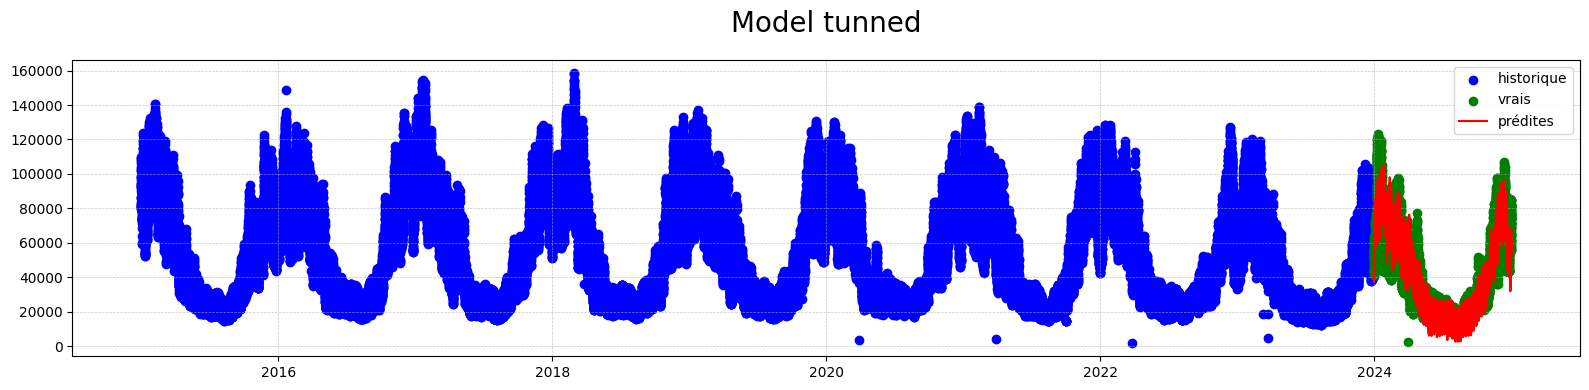

In [27]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.scatter(y_train.index, y_train, label="historique", color="blue")
ax.scatter(y_test.index, y_test, label="vrais", marker="o", color="green")
ax.plot(y_test.index, y_pred_tuned_final, label="prédites", color="red")
ax.grid(True, alpha=0.7, ls='--', lw=0.5)
ax.legend(loc='best')
ax.set_title("Model tunned", pad=20, fontsize=20)
plt.tight_layout()
plt.savefig("../../annex/annex_project2/XGBoost_model_tunned.png")
plt.show()

## feature importances

<Figure size 1200x1200 with 0 Axes>

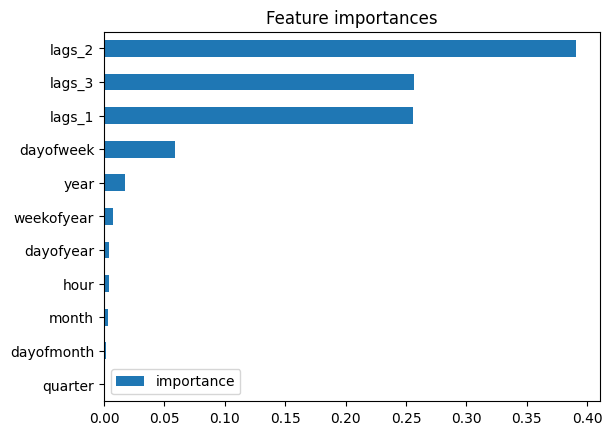

In [28]:
fi = pd.DataFrame(data = model_tuned.feature_importances_, index = model_tuned.feature_names_in_, columns=["importance"])
plt.figure(figsize=(12, 12))
fi.sort_values(by="importance", ascending=True).plot(kind="barh", title="Feature importances")
plt.savefig("../../annex/annex_project2/Feature_importances.png")

# Re-train the model on the complete Dataset ->leverage all datas

In [29]:
X_all = df[features]
y_all = df[target]

#Changing n_estimators to 2100 because it is when it starts to overfit
model_tuned.set_params(n_estimators=2100)

model_tuned.fit(X_all, y_all, eval_set = [(X_all, y_all)], verbose=100)

[0]	validation_0-rmse:26077.91658
[100]	validation_0-rmse:11484.24559
[200]	validation_0-rmse:11118.87229
[300]	validation_0-rmse:10946.66952
[400]	validation_0-rmse:10828.57703
[500]	validation_0-rmse:10738.12206
[600]	validation_0-rmse:10664.15838
[700]	validation_0-rmse:10600.71314
[800]	validation_0-rmse:10545.29564
[900]	validation_0-rmse:10494.88401
[1000]	validation_0-rmse:10450.37203
[1100]	validation_0-rmse:10409.29701
[1200]	validation_0-rmse:10372.52426
[1300]	validation_0-rmse:10339.45365
[1400]	validation_0-rmse:10308.95378
[1500]	validation_0-rmse:10281.44775
[1600]	validation_0-rmse:10256.06172
[1700]	validation_0-rmse:10232.03926
[1800]	validation_0-rmse:10210.15995
[1900]	validation_0-rmse:10190.17003
[2000]	validation_0-rmse:10171.08300
[2099]	validation_0-rmse:10153.33956


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.1, grow_policy='depthwise',
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=1,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2100,
             n_jobs=-1, num_parallel_tree=None, ...)

# Forecasting

In [30]:
#Create future dataFrame to store future predictions
dates = pd.date_range(start=df.index.max()+ pd.DateOffset(hour=1) + pd.offsets.MonthBegin(1), periods=24*365, freq="1h")
df_futur = pd.DataFrame(index=dates)
df["isFuture"] = False
df_futur["isFuture"] = True

#Concatenate the two DataFrames 
df_all = pd.concat([df, df_futur], axis=0)

#Creating the features
df_all = create_features(df_all)
df_all = add_lags(df_all, col="Total_gas_consumption")

df_w_features = df_all[df_all["isFuture"] == True].copy()
df_w_features['pred'] = model_tuned.predict(df_w_features[features])

<Axes: >

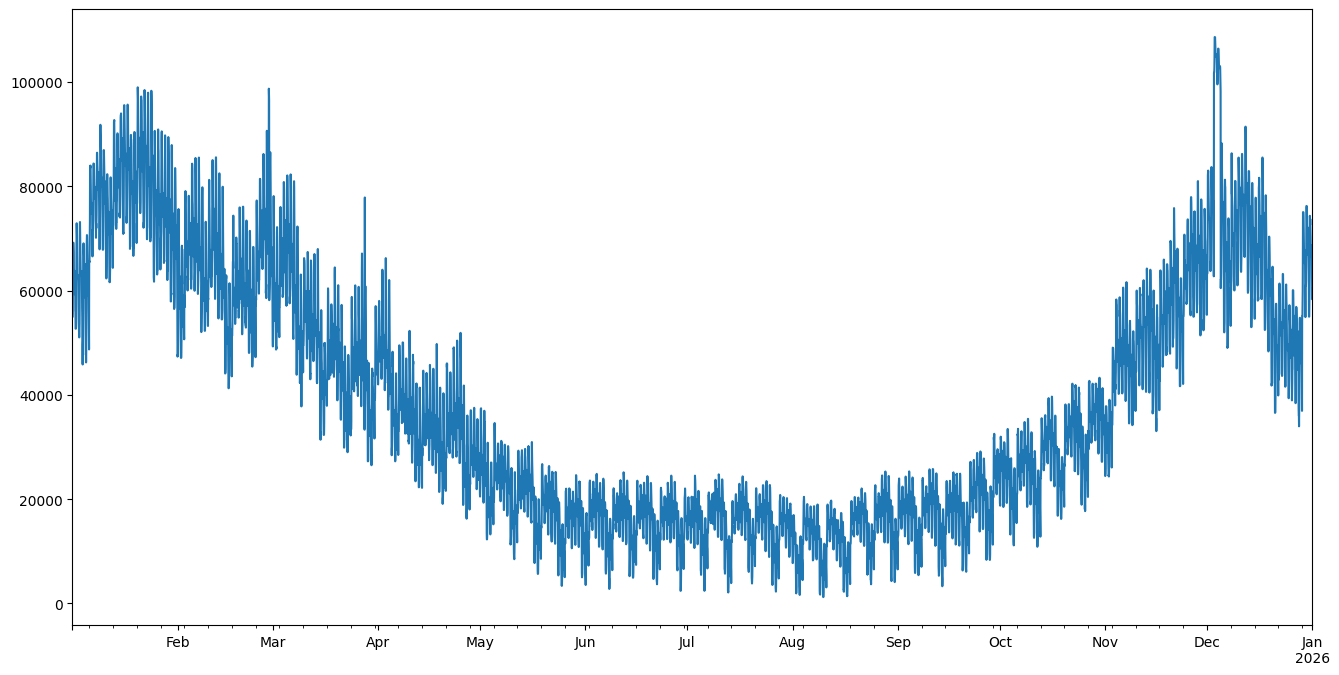

In [31]:
df_w_features['pred'].plot(figsize=(16,8))

# Visualize the forecasts with the rest of the dataset

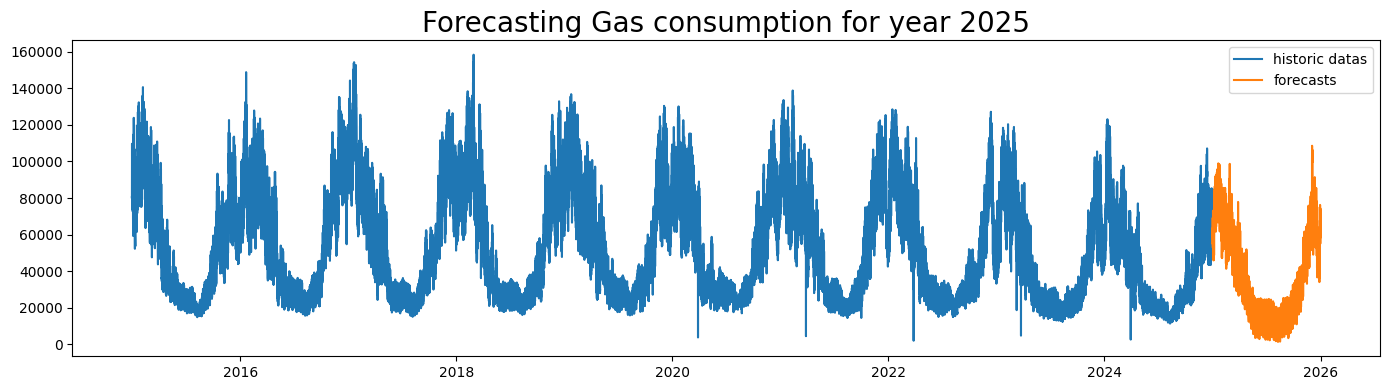

In [32]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(df.index, df["Total_gas_consumption"])
ax.plot(df_w_features.index, df_w_features["pred"])
ax.legend(["historic datas", "forecasts"])
ax.set_title("Forecasting Gas consumption for year 2025", fontsize=20)
plt.tight_layout()
plt.savefig("../../annex/annex_project2/Forecasts_with_history.png")
plt.show()

## Save the model

In [33]:
model_tuned.save_model("model_xgboost.json")